## LAB-2: Classification using KNN, RF, MLP

# Imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


## Visualization

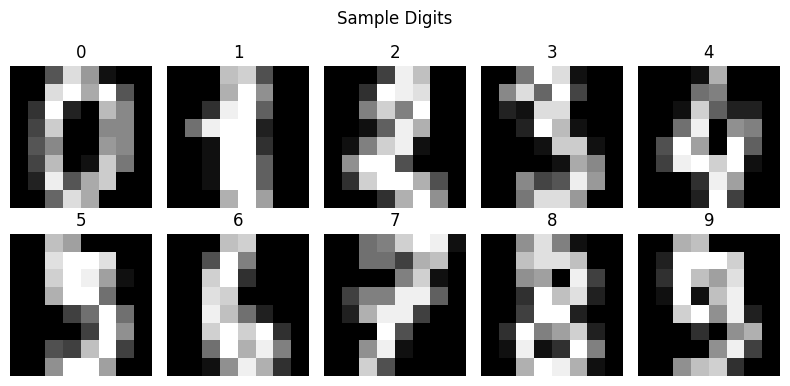

In [5]:
digits = load_digits()
X = digits.data
y = digits.target
images = digits.images

plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"{y[i]}")
    plt.axis("off")
plt.suptitle("Sample Digits")
plt.tight_layout()
plt.show()


# Splitting
Splitting the dataset into training and testing sets.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# KNN Model
KNN predicts the label of a new data point based on the labels of its ‘k’ closest points in the training data.

In [8]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 13, 15, 20]}

# Random Forest Model
A Random Forest builds many decision trees during training and combines their outputs to make a more accurate and stable prediction

In [9]:
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "rf__n_estimators": [25, 50, 100, 200, 500],
    "rf__max_depth": [None, 10, 20]}


# Multilayer Perceptron Model
MLP consists of layers of interconnected nodes (neurons) where each neuron applies a transformation to its inputs, allowing the network to learn complex, non-linear patterns in the data.

In [10]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ))
])

mlp_param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (64, 64)],
    "mlp__activation": ["relu", "tanh"],
    #"mlp__alpha": [0.0001, 0.001],
    "mlp__learning_rate_init": [0.001, 0.01, 1.0, 5.0, 10.0]
}


# Training the model


In [11]:
def train_with_timing(pipeline, param_grid):
    start = time.time()
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring="f1_weighted",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    train_time = time.time() - start
    return grid, train_time

knn_grid, knn_train_time = train_with_timing(knn_pipeline, knn_param_grid)
rf_grid, rf_train_time = train_with_timing(rf_pipeline, rf_param_grid)
mlp_grid, mlp_train_time = train_with_timing(mlp_pipeline, mlp_param_grid)


# Inferencing the model


In [12]:
def inference_time(model):
    start = time.time()
    model.predict(X_test)
    return time.time() - start

knn_test_time = inference_time(knn_grid.best_estimator_)
rf_test_time = inference_time(rf_grid.best_estimator_)
mlp_test_time = inference_time(mlp_grid.best_estimator_)

# Evaluation


In [13]:
def evaluate_model(model):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-score": f1_score(y_test, y_pred, average="weighted")
    }

knn_metrics = evaluate_model(knn_grid.best_estimator_)
rf_metrics = evaluate_model(rf_grid.best_estimator_)
mlp_metrics = evaluate_model(mlp_grid.best_estimator_)

# Result with comparison


               Accuracy  Precision    Recall  F1-score  Training Time (s)  \
KNN            0.969444   0.969666  0.969444  0.969287           4.215932   
Random Forest  0.977778   0.978417  0.977778  0.977820           3.651270   
MLP            0.980556   0.980832  0.980556  0.980577           1.860954   

               Inference Time (s)  
KNN                      1.502205  
Random Forest            0.029619  
MLP                      0.001840  


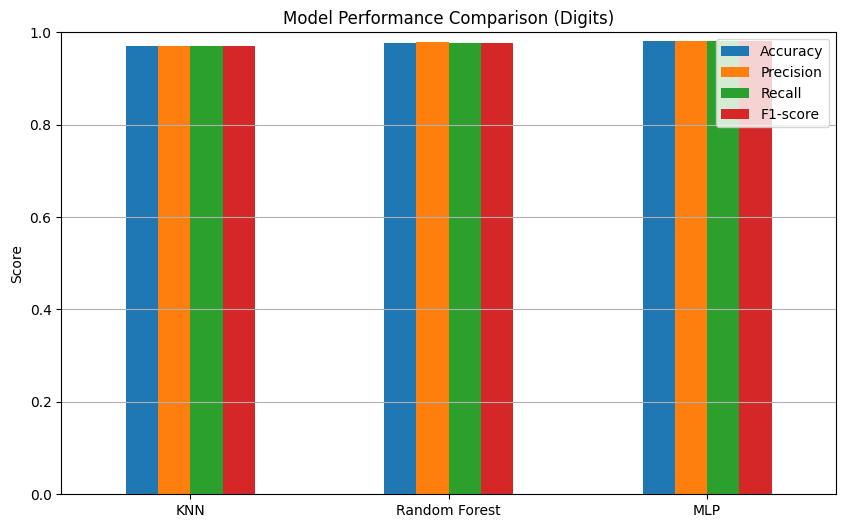

In [15]:
results_df = pd.DataFrame(
    [knn_metrics, rf_metrics, mlp_metrics],
    index=["KNN", "Random Forest", "MLP"]
)

results_df["Training Time (s)"] = [
    knn_train_time, rf_train_time, mlp_train_time
]

results_df["Inference Time (s)"] = [
    knn_test_time, rf_test_time, mlp_test_time
]

print(results_df)

results_df.iloc[:, :4].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison (Digits)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

# Confusion Matrix 
A confusion matrix is a table that summarizes the performance of a classification model by showing the counts of correct and incorrect predictions for each class, directly helping to assess misclassification errors.


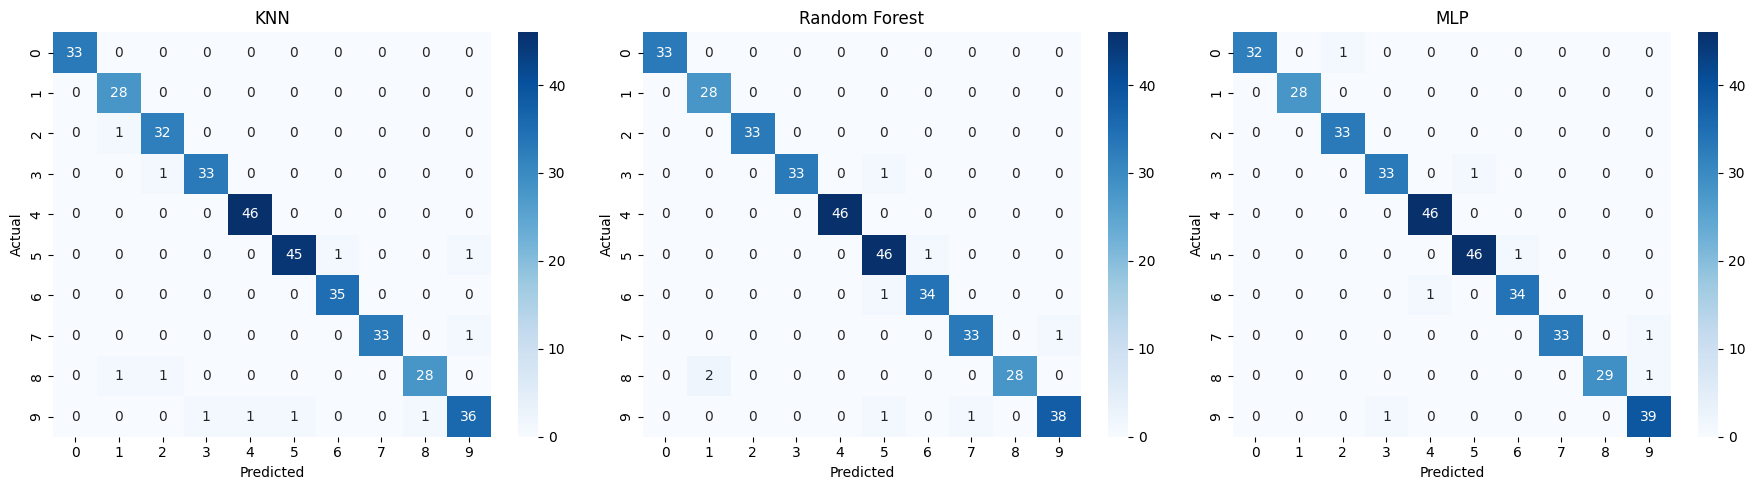

In [16]:
models = {
    "KNN": knn_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "MLP": mlp_grid.best_estimator_
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()